# Quant GANs: Deep Generation of Financial Time Series
In this notebook we replicate the different steps developped in [Wiese et al., Quant GANs: Deep Generation of Financial Time Series, 2019](https://arxiv.org/abs/1907.06673) to generate synthetic financial series.

## Timeseries: Fetching and Characteristics
In the first chapter, we use the yfinance module to obtain financial series. In this notebook we focus on equity series. We illustrate the characteristics of the financial series that we seek to replicate in synthetic data.

In [16]:
# We use yfinance to download our targeted financial variables, the daily close price for the CAC40.
!pip install yfinance -q
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

os.chdir('/home/davidg/Documents/Cours/MLforFinance/temporalCN')
os.makedirs('./figure/',exist_ok=True)
os.makedirs('./table/',exist_ok=True)

tickers_list = ['^FCHI',]
names  = ['CAC40',]
n_dict = dict(zip(tickers_list,names))
df     = pd.DataFrame(yf.download(tickers_list,'1990-1-1')['Adj Close'])
df     = df.rename(columns={'Adj Close':names[0]})

[*********************100%***********************]  1 of 1 completed


We plot our series of interest, the series is non stationary.

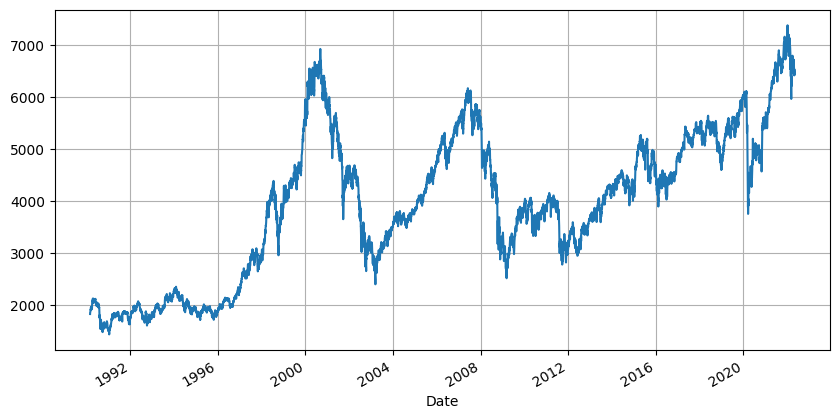

In [17]:
ax = df.plot(figsize=(10,5), legend=False)
ax.grid(True)
plt.savefig('./figure/CAC40.png', dpi=300)
plt.show()

The next plots show the returns for the CAC40 and its autocorrelation at various lag orders.

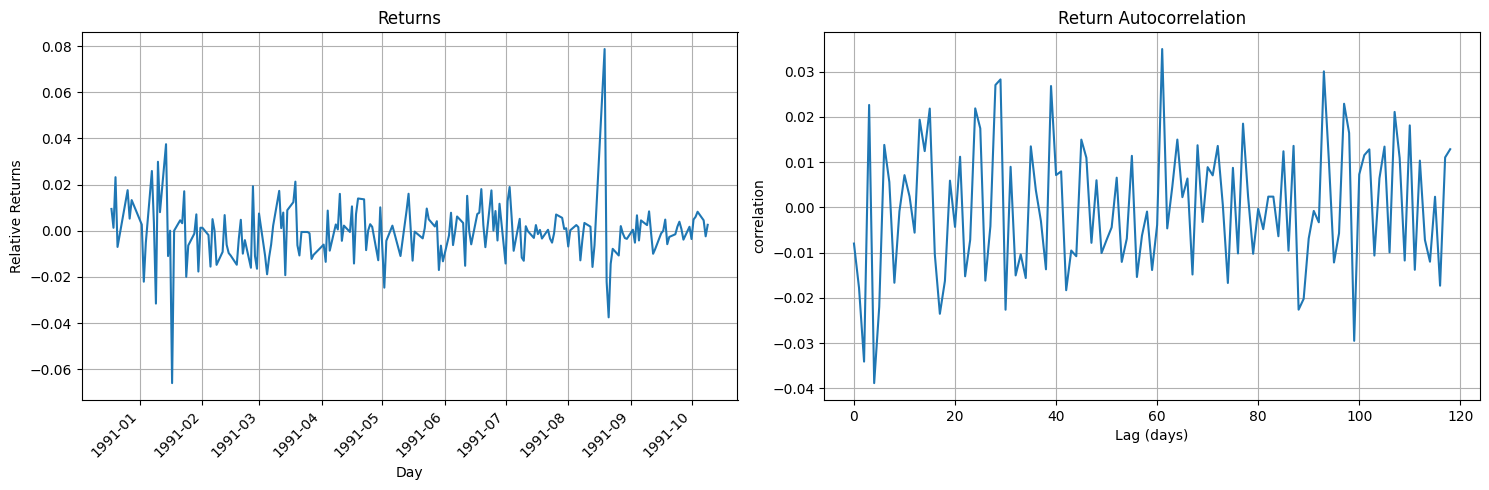

In [18]:
from preprocess.acf import acf, rolling_window
returns = df.shift(1)/df - 1
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

axs[0].plot(returns[200:400])
axs[0].set_title('Returns')
axs[1].plot(acf(returns, 120)[1:])
axs[1].set_title('Return Autocorrelation')

for ax in axs: ax.grid(True)
plt.setp(axs[0], xlabel='Day')
plt.setp(axs[0].get_xticklabels(), rotation=45, ha='right')
plt.setp(axs[1], xlabel='Lag (days)')
plt.setp(axs[0], ylabel='Relative Returns')
plt.setp(axs[1], ylabel='Autocorrelation')
axs[1].set_ylabel('correlation')
plt.tight_layout()
plt.savefig('./figure/returns_val_corr.png', dpi=300)
plt.show()

### Log Returns as Financial Data
We also present log returns. They  have various advantages over simple returns (they are approximately normal, they are equal to cumulative return of the asset/portfolio and they are symmetric).
We calculate the log return series as,
$$r_t = \log\biggl(\frac{s_t}{s_{t-1}}\biggr) \text { for all } t \in \{1, ..., T\}.$$
Here we illustrate some of the stylized facts from [Chakraborti et al., 2011].
First, log returns are not autocorrelated.

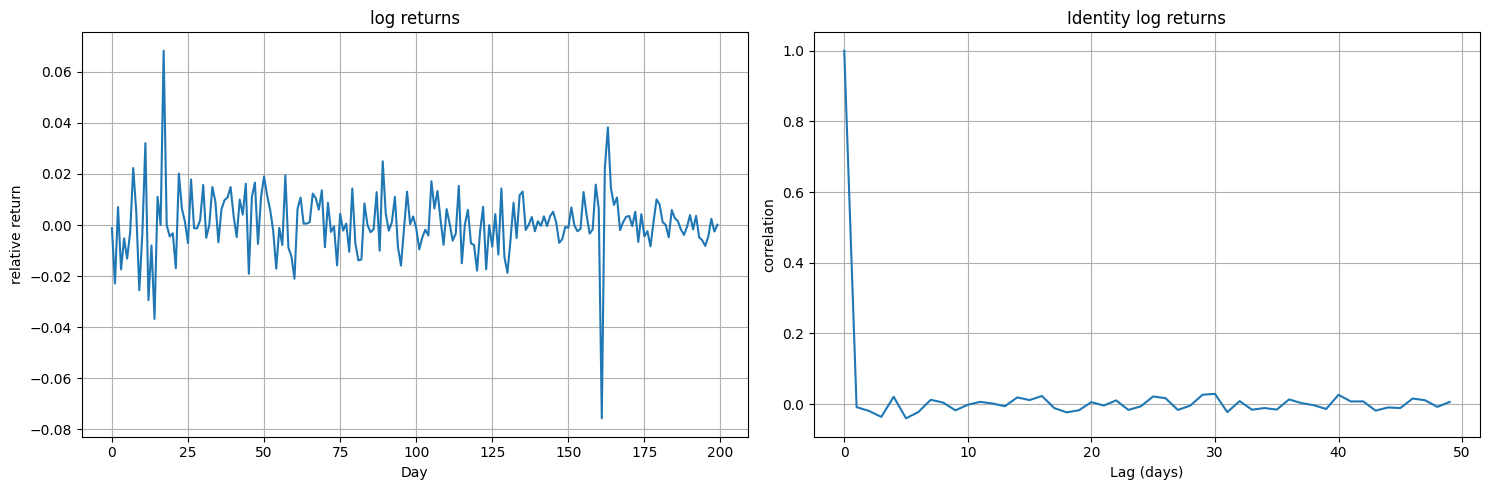

In [19]:
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

axs[0].plot(log_returns[200:400])
axs[0].set_title('log returns')
axs[1].plot(acf(log_returns, 50))
axs[1].set_title('Identity log returns')

for ax in axs: ax.grid(True)
plt.setp(axs[0], xlabel='Day')
plt.setp(axs[1], xlabel='Lag (days)')
plt.setp(axs[0], ylabel='relative return')
plt.setp(axs[1], ylabel='autocorrelation')
axs[1].set_ylabel('correlation')
plt.tight_layout()
plt.savefig('./figure/log_returns_val_corr.png', dpi=300)
plt.show()

 Second, the volatility of asset returns negatively correlates with the return process, something known as leverage effect. Here we show the autocorrelation of log returns with its lagged standard deviation.

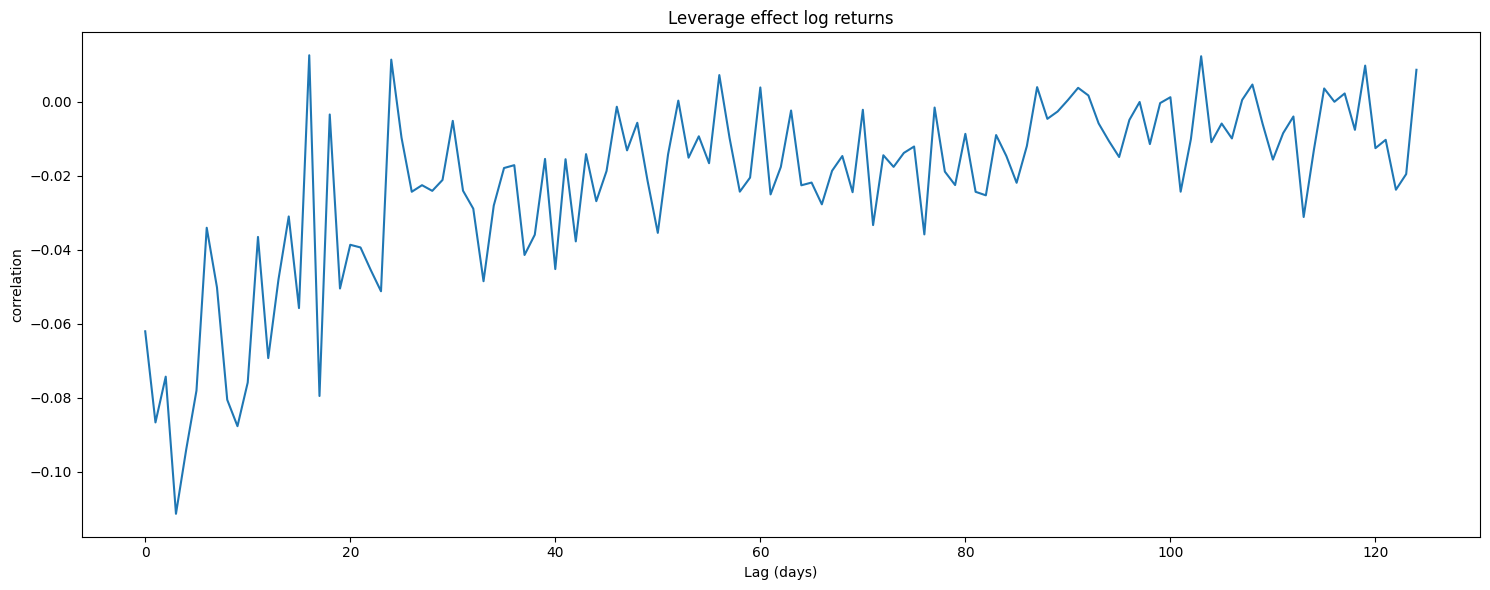

In [20]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(acf(log_returns, 125, le=True))
ax.set_title('Leverage effect log returns')
plt.setp(ax, xlabel='Lag (days)')
plt.setp(ax, ylabel='autocorrelation')
ax.set_ylabel('correlation')
plt.tight_layout()
plt.savefig('./figure/leverage_effect.png',dpi=300)
plt.show()

Prior to passing a realization of a financial time series $s_{0:T} ∈ \mathbb{R}^{N_X×(T+1)}$ to the discriminator, the time series has to be preprocessed. The applied pipeline is described in the report. We briefly explain each of the steps taken. Note that all of the used transformations, excluding the rolling window, are invertible and thus, allow a series sampled from a log return NP to be post-processed by inverting the steps 1-4 to obtain the desired form. Also, observe that the pipeline includes the inverse Lambert W transformation as earlier discussed in subsection 5.3.

## Preprocessing
The data need to be preprocessed before being brought to the model. We describe each step separately.

Step 1: Normalization
For numerical reasons, we normalize the data in order to obtain a series with zero mean and unit variance, which is thoroughly derived in LeCun et al. (1998).

In [21]:
from sklearn.preprocessing import StandardScaler
from preprocess.gaussianize import Gaussianize, norm

gaussianize, standardScaler1, standardScaler2 = Gaussianize(), StandardScaler(), StandardScaler()
log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))

/home/davidg/Documents/Cours/MLforFinance/temporalCN/preprocess/gaussianize.py:179: UserWarning: Warning: No convergence after 100 iterations. Increase max_iter.
  warnings.warn("Warning: No convergence after %d iterations. Increase max_iter." % max_iter)


Step 2: Inverse Lambert W transform
The suggested transformation applied to the log returns of the CAC40 is displayed in Figure 10. It shows the standardized original distribution of the CAC40 log returns and the inverse Lambert W transformed log return distribution. Observe that the transformed standardized log return distribution in Figure 10b approximately follows the standard normal distribution and thereby circumvents the issue of not being able to generate the heavy-tail of the original distribution.

# Step 3: Rolling window
When considering a discriminator with receptive field size $T^{(d)}$, we apply a rolling window of corresponding length and stride one to the preprocessed log return sequence $r^{(ρ)}_t $. Hence, for $t∈\{1,...,T −T^{(d)}\}$ we define the sub-sequences $$r^{(t)}_{1:T^{(d)}} := r^{(ρ)}_{t:(T^{(d)}+t−1)} ∈  \mathbb{R}^{N_Z×T^{(d)}}.$$

Remark 6.1. Note that sliding a rolling window introduces a bias, since log returns at the beginning and end of the time series are under-sampled when training the Quant GAN. This bias can be corrected by using a (non-uniform) weighted sampling scheme when sampling batches from the training set.

In [22]:
# We use a receptive field of size 127 as in the paper.
log_returns_rolled = rolling_window(log_returns_preprocessed, 127)

Because log returns exhibit fat tail and are more piked than gaussian variables, Lambert W transformation can be applied to bring log returns to gaussianity and improve the performances of methods meant for normalized Gaussian data.
Here we show log returns before and after the lambert W inverse transform respectively (both standardized). 

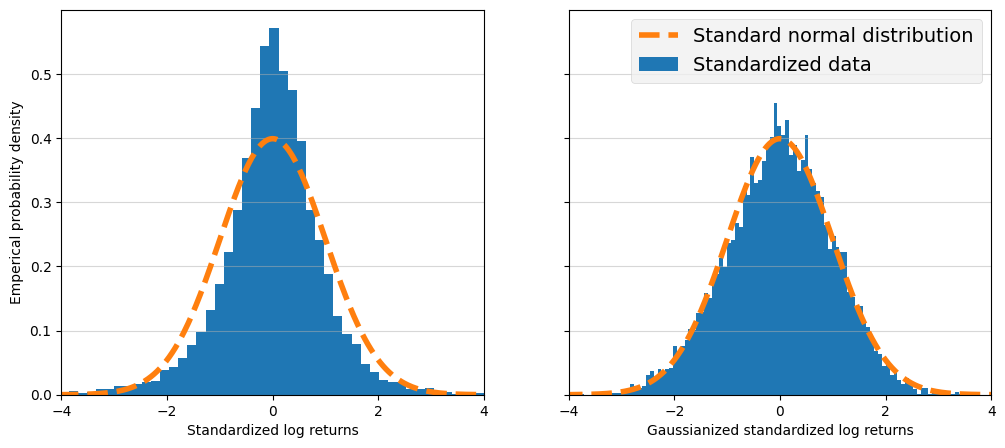

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5), sharey=True, sharex=True)
plt.style.use('fivethirtyeight')

ax[0].hist(standardScaler1.transform(log_returns), bins=100, density=True)
x_range = np.linspace(*ax[0].get_xlim(), num=1000)
ax[0].plot(x_range, norm.pdf(x_range), linestyle='dashed')

ax[1].hist(log_returns_preprocessed, bins=100, density=True)
x_range = np.linspace(*ax[1].get_xlim(), num=1000)
ax[1].plot(x_range, norm.pdf(x_range), linestyle='dashed')

# add a grid to compare easily
ax[0].yaxis.grid(True, alpha=0.5)
ax[1].yaxis.grid(True, alpha=0.5);

ax[1].legend(['Standard normal distribution', 'Standardized data'])
ax[0].set_ylabel('Emperical probability density')
ax[0].set_xlabel('Standardized log returns')
ax[1].set_xlabel('Gaussianized standardized log returns')

ax[0].set_xlim(-4, 4)
plt.savefig('./figure/empirical_distributions.png',dpi=300)
plt.show()

## Quant GAN model
In this second part we construct the GAN model used to generate syntetic financial series with properties similar to those presented above.

### Preprocessing
Here we set the different parameters and options required for the implementation of Quant GAN. The different modeling choices for the model parameters are descibed in the paper and primarily driven by performances.

In [24]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset
from model.torch_tcn import *

# Set gpu if available
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
device = torch.device("cpu")

# Set optmization parameters
num_epochs = 100
nz         = 3
batch_size = 20
seq_len    = 127
clip       = 0.01
lr         = 0.0002

Using GPU.


### Dataset
We construct a torch dataloader to feed batches of data to the generator and discriminator.

In [25]:
# Dataloader
class Loader32(Dataset):
    '''Brings batches from df of length lenght sequentially.'''
    def __init__(self, df, length):
        assert len(df) >= length
        self.df = df
        self.length = length
    
    def __getitem__(self, idx):
        return torch.tensor(self.df[idx:idx+self.length]).reshape(-1, self.length).to(torch.float32)
        
    def __len__(self):
        return max(len(self.df)-self.length, 0)

The target we try to replicate are the log returns preprocessed. Remember this is the log returns where we applied the following steps:
- Normalize
- Inverse Lambert W transform
- Normalize
- Rolling Window

Here, we set some final options for the data loader, especially the size of the receptive field.


In [26]:
generator_path = './trained/'
file_name = 'CAC40_daily'

receptive_field_size     = 127  
log_returns_preprocessed = rolling_window(log_returns_preprocessed, receptive_field_size)
data_size = log_returns.shape[0]
print(log_returns_preprocessed.shape)
print(data_size)

(127, 8036, 1)
8162


In [31]:
import torch.optim as optim
from tqdm import tqdm
# Load the generator onto GPU if available
generator = Generator().to(device)

# This is the training loop
train = False
if train:
    discriminator  = Discriminator(seq_len).to(device)
    disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr)
    gen_optimizer  = optim.RMSprop(generator.parameters(), lr=lr)

    dataset = Loader32(log_returns_preprocessed, 127)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    dataset = Loader32(log_returns_preprocessed, 1)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    t = tqdm(range(num_epochs))
    for epoch in t:
        for idx, data in enumerate(dataloader, 0):

            discriminator.zero_grad()
            real = data.to(device)
            batch_size, seq_len = real.size(0), real.size(1)
            noise = torch.randn(batch_size, nz, seq_len, device=device)
            fake  = generator(noise).detach()
            real  = real.reshape(batch_size,1,-1)

            disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
            disc_loss.backward()
            disc_optimizer.step()
            # print(disc_loss)
            for dp in discriminator.parameters():
                dp.data.clamp_(-clip, clip)
    
            if idx % 5 == 0:
                generator.zero_grad()
                gen_loss = -torch.mean(discriminator(generator(noise)))
                gen_loss.backward()
                gen_optimizer.step()            
        t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))
            
    # Save
    torch.save(generator, f'{generator_path}trained_generator_{file_name}_epoch_{epoch}.pth')

else:
    # Load
    file_name = 'SP500_daily'
    generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')
    generator.eval()

Here we create some synthetic series using the estimated GAN. To do so we create a log return series, and use the reverse transformations used to process the original data.

In [32]:
pp    = 80
generator.eval()
noise = torch.randn(pp,3,receptive_field_size).to(device)
y     = generator(noise).cpu().detach().squeeze();

y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to redue the tendency of GAN to produce extreme returns
y  = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()

This are the different generated timeseries.

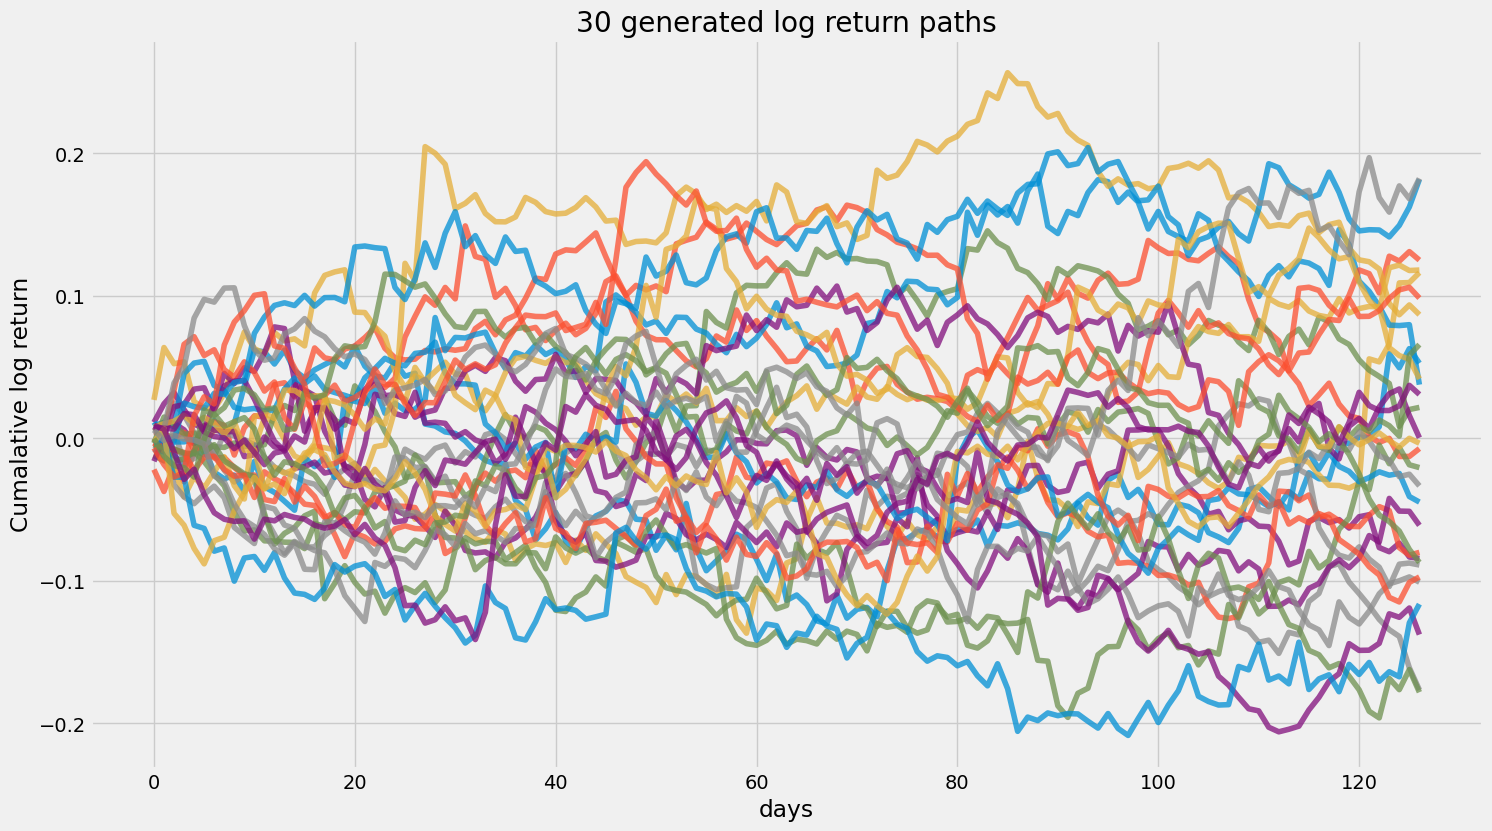

In [33]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:30], axis=1).T, alpha=0.75)
ax.set_title('30 generated log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');
plt.savefig('./figure/log_returns_series.png',dpi=300)
plt.show()
n_bins  = 50
windows = [1, 5, 20, 100]

Even with basic settings, their properties are close to the real data as shown in the following histograms.

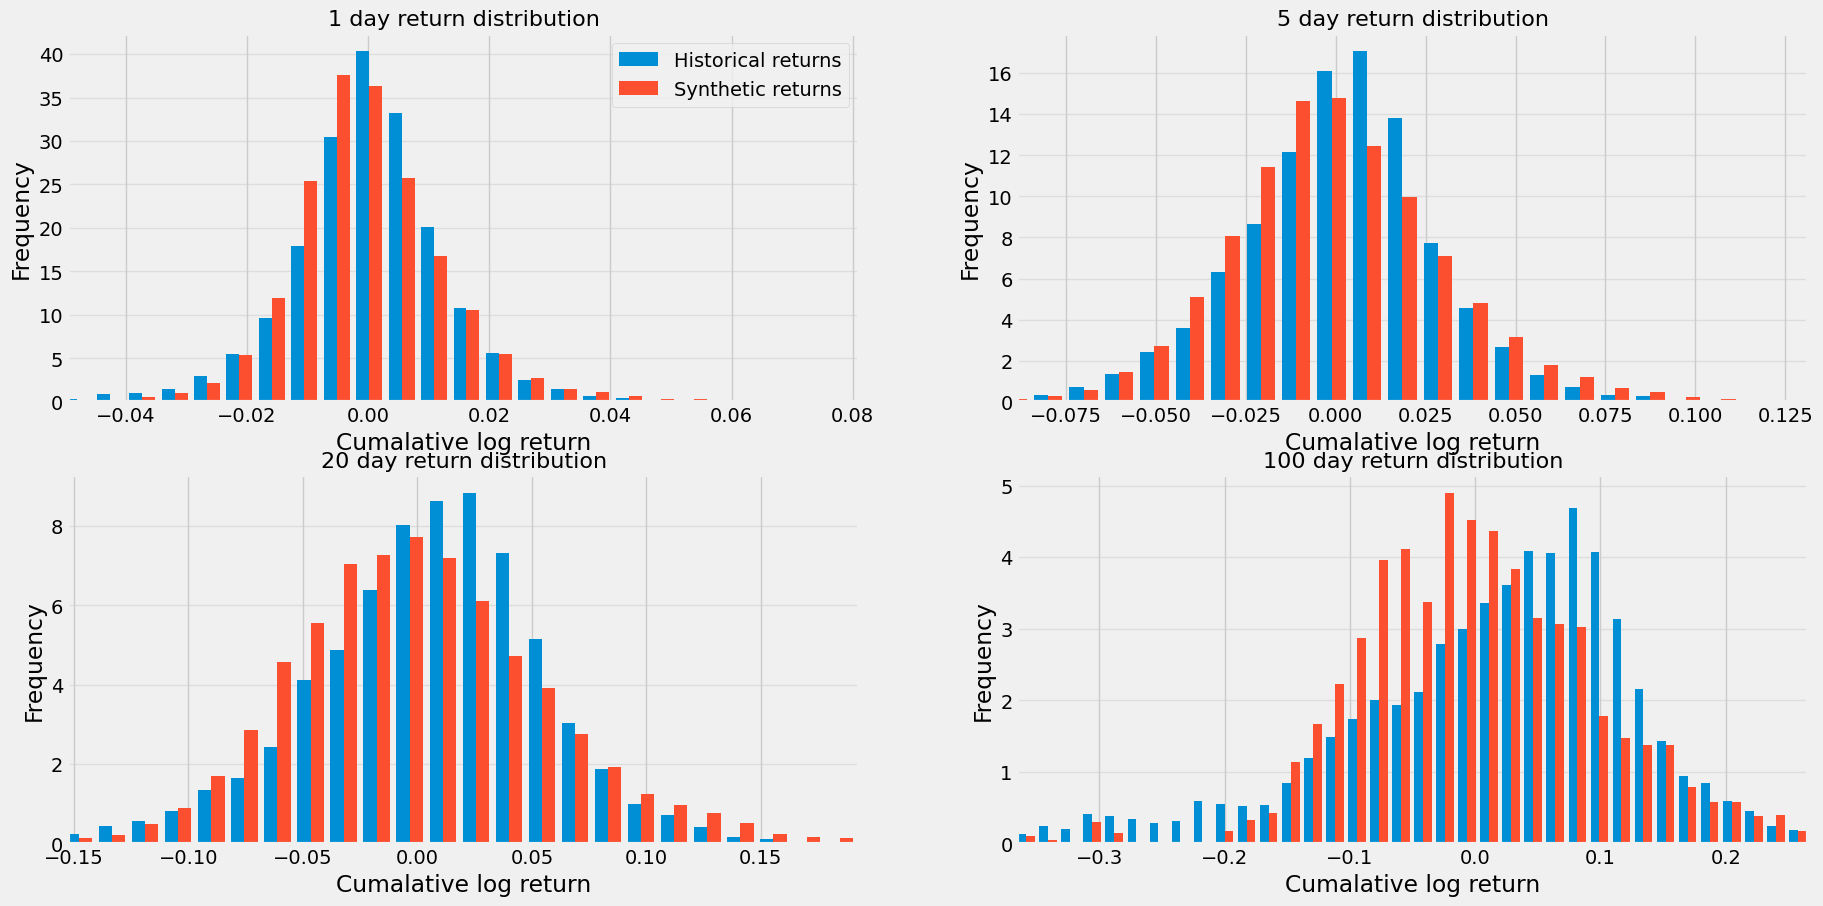

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumalative log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])
plt.savefig('./figure/synthetic_distributions.png',dpi=300)
plt.show()

Here we present some of the autocorrelations for the synthetic data and compare it to their real counterparts.

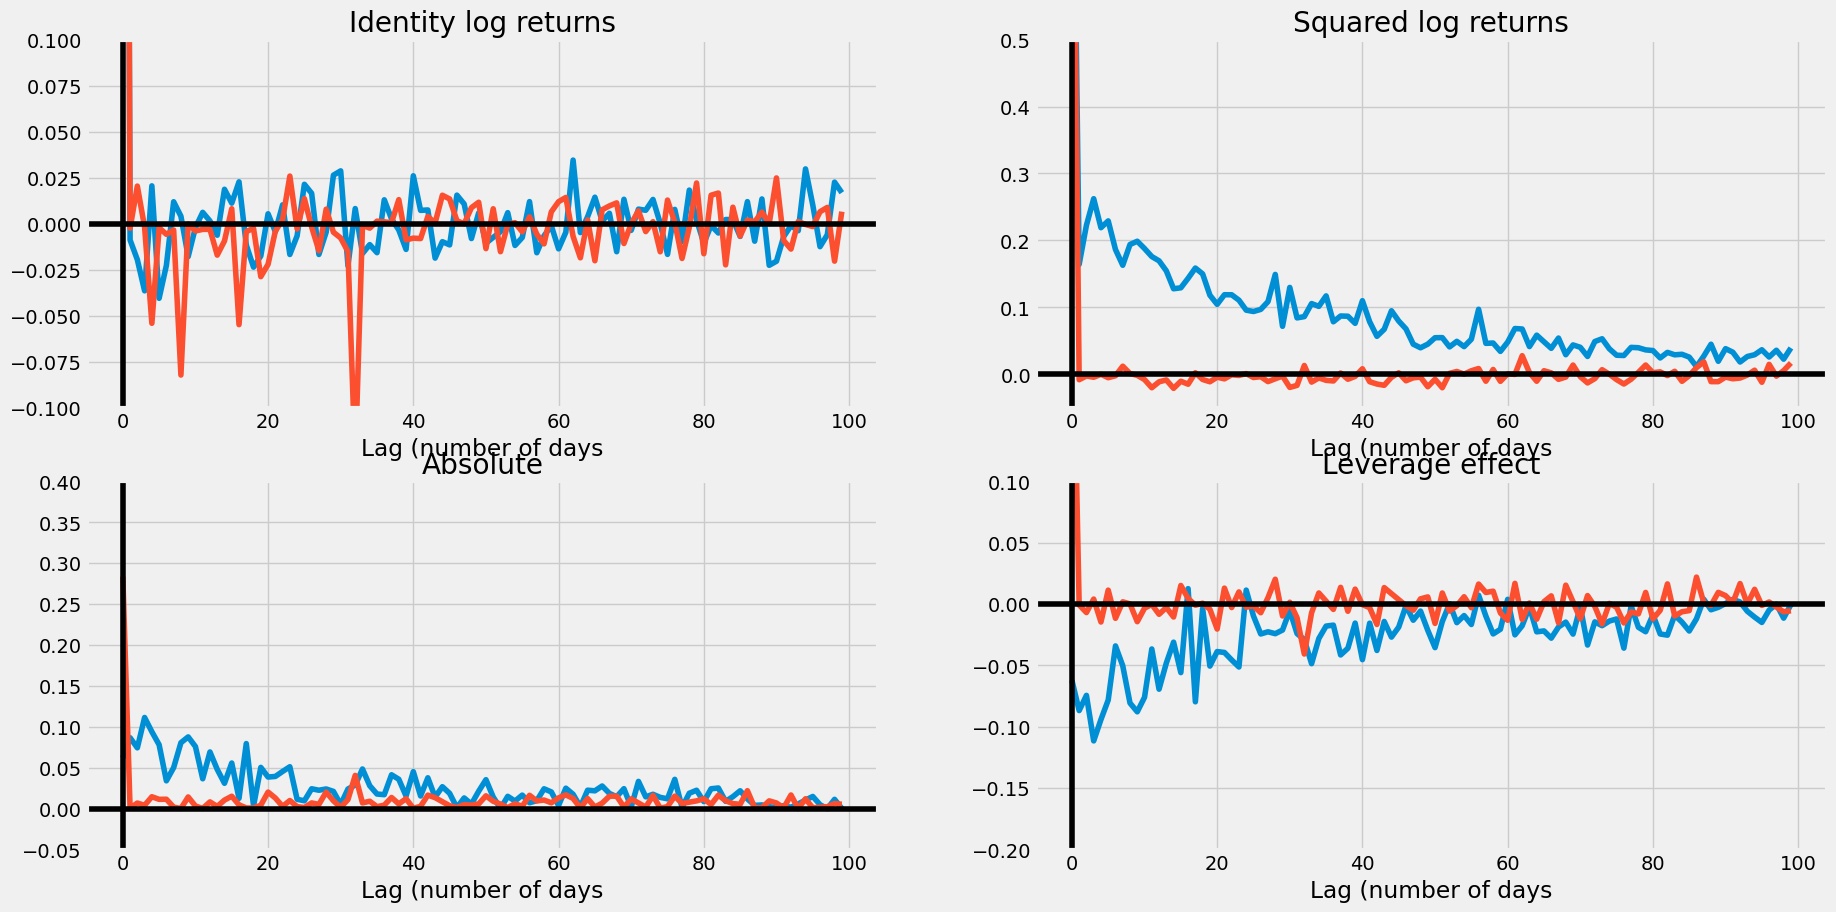

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axs[0,0].plot(acf(log_returns, 100))
axs[0,0].plot(acf(y.T, 100).mean(axis=1))
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Identity log returns')
axs[0,1].plot(acf(log_returns**2, 100))
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].plot(acf(y.T**2, 100).mean(axis=1))
axs[0,1].set_title('Squared log returns')
axs[1,0].plot(abs(acf(log_returns, 100, le=True)))
axs[1,0].plot(abs(acf(y.T, 100, le=True).mean(axis=1)))
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute')
axs[1,1].plot(acf(log_returns, 100, le=True))
axs[1,1].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage effect')

for ax in axs.flat: 
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
plt.setp(axs, xlabel='Lag (number of days')

plt.savefig('./figure/synthetic_leverage.png',dpi=300)
plt.show()

## Evaluation of the synthtetic series
This section shows different distance to assess the proximity of the synthetic series to their observed counterpart.
The earth mover distance describes how much probability mass has to be moved to transform Ph into Pg.

In [36]:
from scipy.stats import wasserstein_distance, norm, kurtosis, skew, skewtest, kurtosistest

windows = pd.Series([1, 5, 20, 100], name='window size')
EMDscores = np.zeros(len(windows))

for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    
    EMDscores[i] = wasserstein_distance(real_dist, fake_dist)

df_EMD = pd.DataFrame({'Earth Mover Distance' : EMDscores}, index=windows)
with open("./table/EMD_Scores.tex", "w") as fh:
    fh.write(df_EMD.to_latex())
df_EMD

,Earth Mover Distance
window size,
1,0.001577
5,0.004169
20,0.011133
100,0.034333


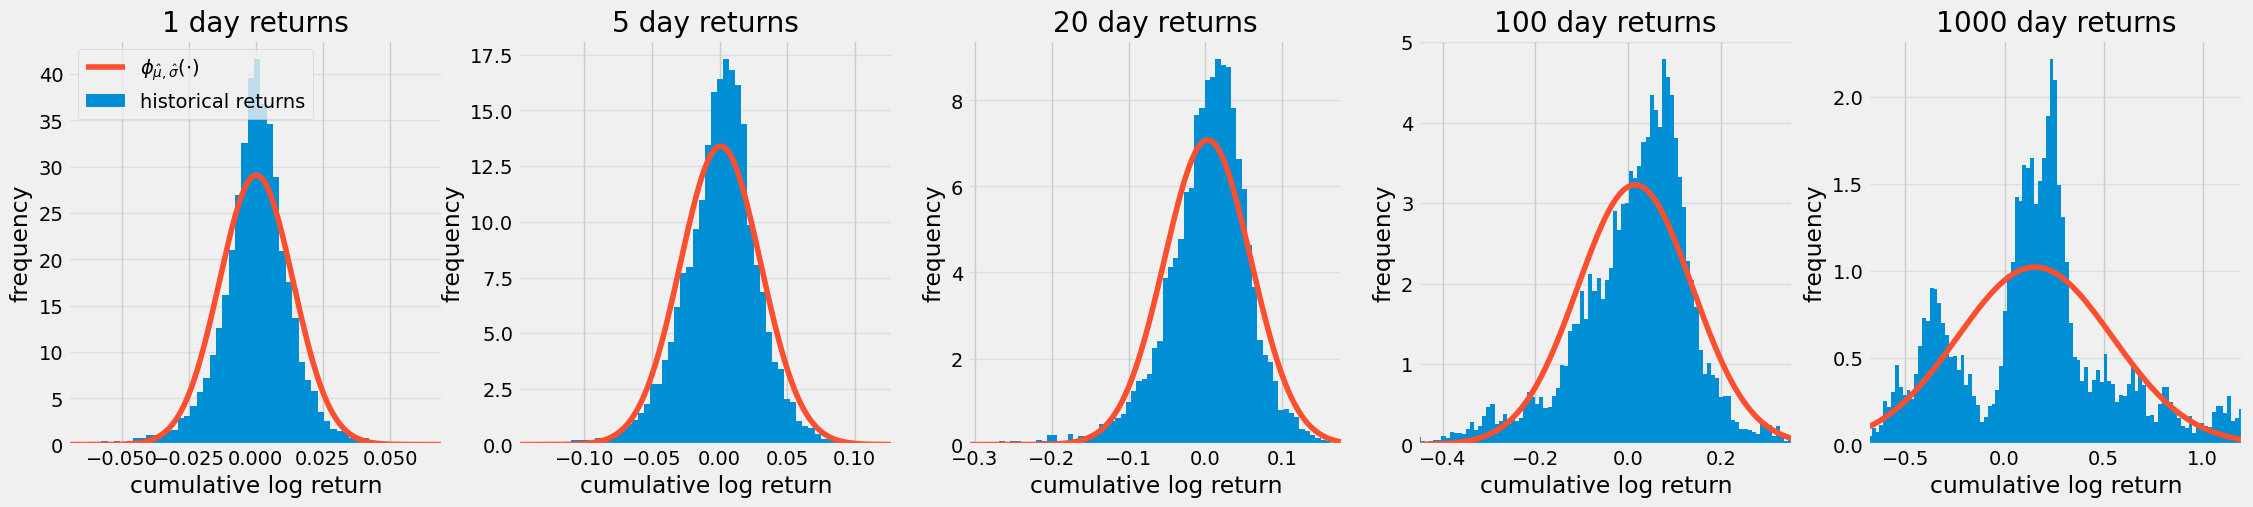

In [37]:
windows = [1, 5, 20, 100, 1000]
n_bins  = 100

fig, ax = plt.subplots(ncols=len(windows), figsize=(5*len(windows),5))
for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    ax[i].hist(real_dist, bins=n_bins, density=True)
    x_range = np.linspace(*ax[i].get_xlim(), 10000)
    ax[i].plot(x_range, norm.pdf(x_range, real_dist.mean(), real_dist.std()))
    ax[i].set_xlim(*np.quantile(real_dist, [0.001, .999]))
    ax[i].set_title('{} day returns'.format(windows[i]))
    ax[i].yaxis.grid(True, alpha=0.5)
    ax[i].set_xlabel('cumulative log return')
    ax[i].set_ylabel('frequency')

ax[0].legend(['$\phi_{\hat{\mu}, \hat{\sigma}}(\cdot)$', 'historical returns'], loc='upper left')
plt.savefig('./figure/real_agg_gauss.png', dpi=300)
plt.show()

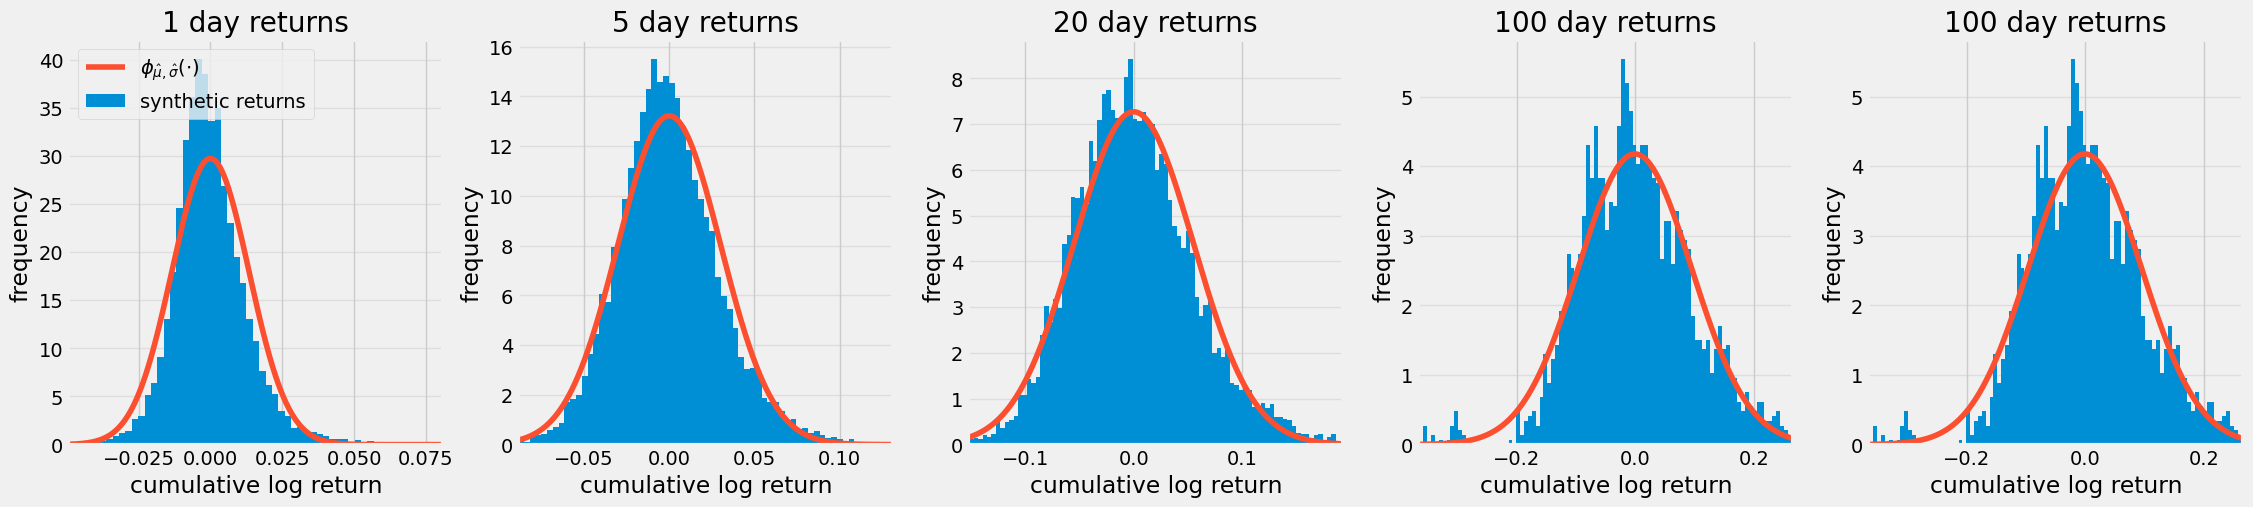

In [38]:
windows = [1, 5, 20, 100, 100]
n_bins = 100

fig, ax = plt.subplots(ncols=len(windows), figsize=(5*len(windows),5))
for i in range(len(windows)):
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    ax[i].hist(fake_dist, bins=n_bins, density=True)
    x_range = np.linspace(*ax[i].get_xlim(), 10000)
    ax[i].plot(x_range, norm.pdf(x_range, fake_dist.mean(), fake_dist.std()))
    ax[i].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    ax[i].set_title('{} day returns'.format(windows[i]))
    ax[i].yaxis.grid(True, alpha=0.5)
    ax[i].set_xlabel('cumulative log return')
    ax[i].set_ylabel('frequency')

ax[0].legend(['$\phi_{\hat{\mu}, \hat{\sigma}}(\cdot)$', 'synthetic returns'], loc='upper left')
plt.savefig('./figure/fake_agg_gauss.png', dpi=300)
plt.show()

In [39]:
windows = pd.Series([1, 5, 20, 100], name='window size')
stats_array = np.zeros((len(windows), 4))

for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).squeeze()
    stats_array[i, 0] = skew(real_dist)
    stats_array[i, 1] = skewtest(real_dist).pvalue
    stats_array[i, 2] = kurtosis(real_dist)
    stats_array[i, 3] = kurtosistest(real_dist).pvalue

stats_df = pd.DataFrame(np.round(stats_array, 3), columns=['skewness', 'skewness p-value', 'kurtosis', 'kurtosis p-value'], index=windows)

with open("./table/stats_real.tex", "w") as fh:
    fh.write(stats_df.to_latex())

stats_df

,skewness,skewness p-value,kurtosis,kurtosis p-value
window size,,,,
1,-0.196,0.0,5.785,0.0
5,-0.565,0.0,4.885,0.0
20,-1.142,0.0,5.157,0.0
100,-0.723,0.0,1.185,0.0


In [40]:
windows = pd.Series([1, 5, 20, 100], name='window size')
stats_array = np.zeros((len(windows), 4))

for i in range(len(windows)):
    fake_di = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    stats_array[i, 0] = skew(real_dist)
    stats_array[i, 1] = skewtest(real_dist).pvalue
    stats_array[i, 2] = kurtosis(real_dist)
    stats_array[i, 3] = kurtosistest(real_dist).pvalue

stats_df = pd.DataFrame(np.round(stats_array, 3), columns=['skewness', 'skewness p-value', 'kurtosis', 'kurtosis p-value'], index=windows)

with open("./table/stats_fake.tex", "w") as fh:
    fh.write(stats_df.to_latex())

stats_df

,skewness,skewness p-value,kurtosis,kurtosis p-value
window size,,,,
1,-0.723,0.0,1.185,0.0
5,-0.723,0.0,1.185,0.0
20,-0.723,0.0,1.185,0.0
100,-0.723,0.0,1.185,0.0


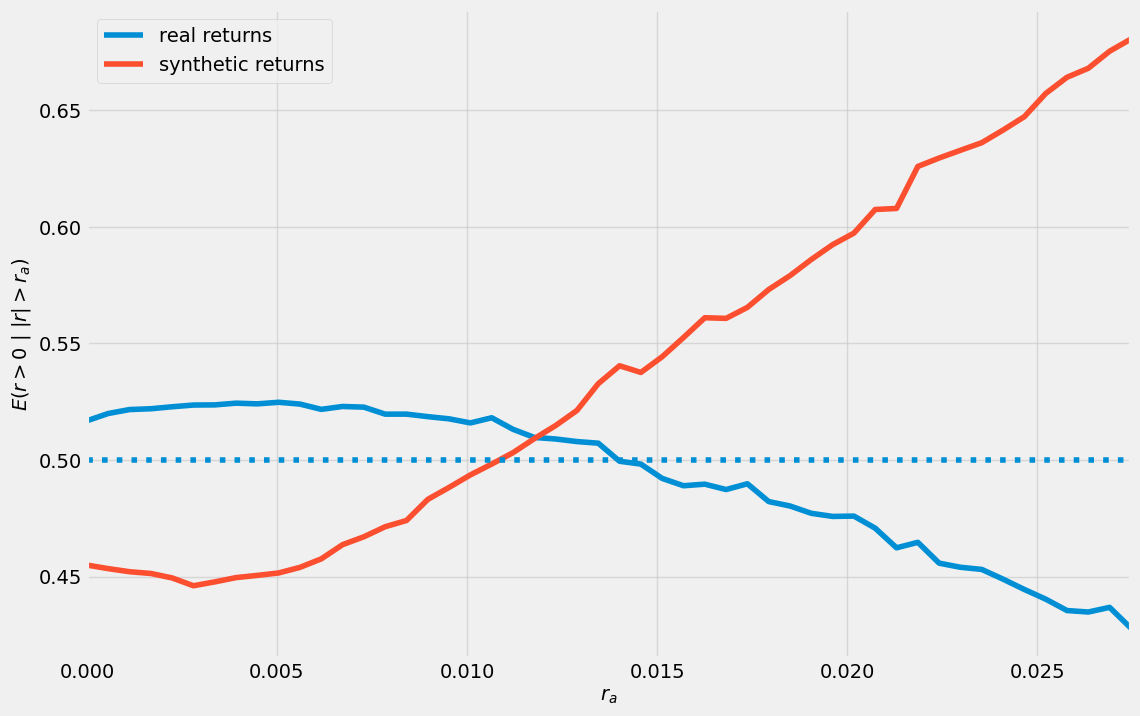

In [41]:
real_dist = log_returns.squeeze()
fake_dist = y.ravel() 

loss_assymetry = lambda dist, x: np.mean((dist[np.abs(dist) > x] >= 0))

fig, ax = plt.subplots(figsize=(12,8))
x_range = np.linspace(0, np.quantile(np.abs(real_dist), .95), 50)
ax.plot(x_range, [loss_assymetry(real_dist, x) for x in x_range], label='real returns')
ax.plot(x_range, [loss_assymetry(fake_dist, x) for x in x_range], label='synthetic returns')
ax.hlines(0.5, -1, 1, linestyles='dotted');
ax.set_xlim(0, np.quantile(np.abs(real_dist), .95))

ax.set_xlabel('$r_a$', size=14)
ax.set_ylabel('$E(r > 0$ | $|r| > r_a)$', size=14)

ax.grid(alpha=0.7)
ax.legend()
plt.savefig('./figure/gl_assymetry.png', dpi=300)
plt.show()

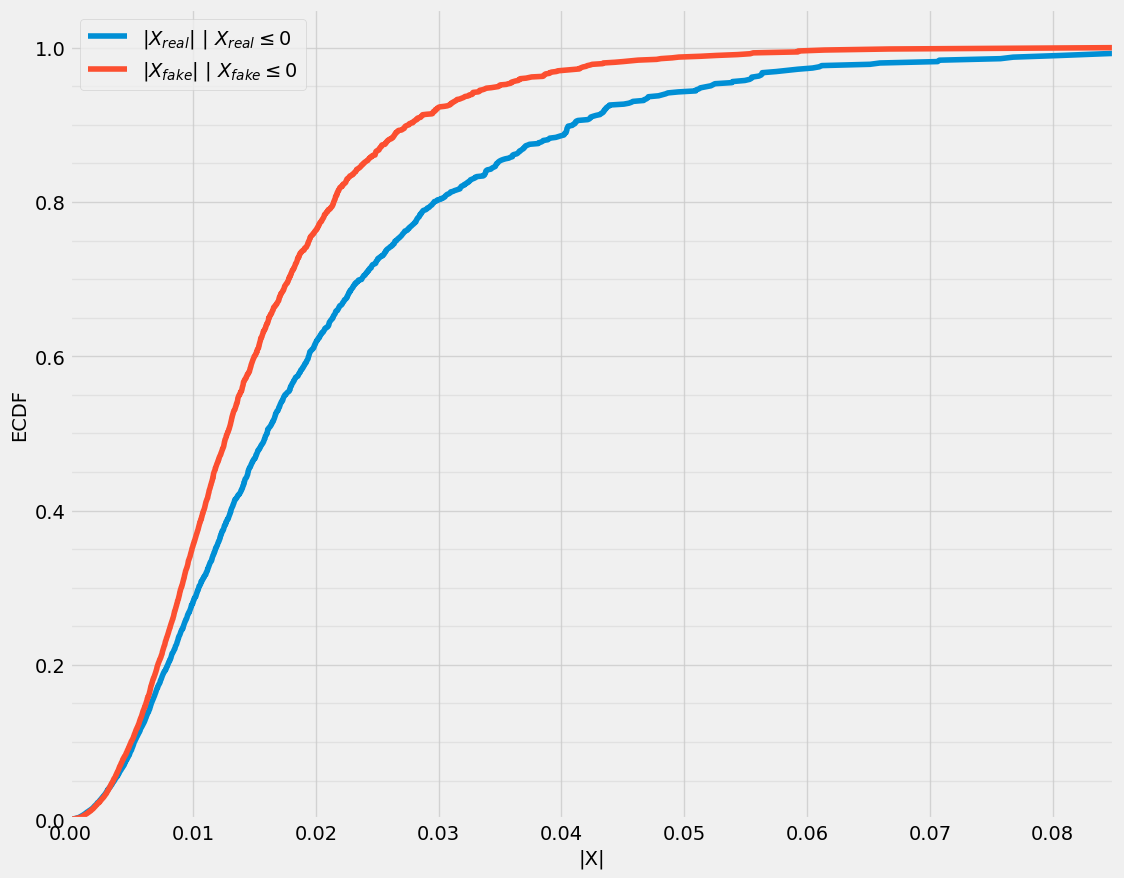

In [42]:
fig, ax = plt.subplots(figsize=(12, 10))

x_real = np.sort(abs(real_dist[real_dist <= 0]))
x_fake = np.sort(abs(fake_dist[fake_dist <= 0]))

plt.plot(x_real, x_real.cumsum()/x_real.sum())
plt.plot(x_fake, x_fake.cumsum()/x_fake.sum())

ax.grid(which='minor', alpha=0.4)
ax.grid(which='major', alpha=0.8)

ax.set_yticks(np.arange(0, 1.2, 0.2))
ax.set_yticks(np.arange(0, 1.05, .05), minor=True)

plt.xlim(0, max(x_fake))
plt.ylim(0, 1.05)
plt.plot([max(x_real), max(x_fake)], [1, 1], color='#1f77b4')
ax.vlines(max(x_real), 0, 1.5, linestyles='dotted')

ax.legend(['$|X_{real}|$ | $X_{real} \leq 0$', '$|X_{fake}|$ | $X_{fake} \leq 0$'])

ax.set_xlabel('|X|', size=14)
ax.set_ylabel('ECDF', size=14)

plt.savefig('./figure/loss_ecdf.png', dpi=300)
plt.show()